# Mass-Luminosity Relation - Nico Keeghan
In this notebook, I will determine the mass-luminosity relation, based on my work from the `luminosity.ipynb` notebook, and Cedric's work in the `masses.ipynb` notebook. I will use a log-log plot and perform a linear fit, for which the slope $\alpha$ will give us the power for the mass-luminosity relation $L\propto M^\alpha$.

We start by importing the necessary libraries.

In [1]:
import numpy as np
import astropy
import matplotlib.pyplot as plt 
from matplotlib import cm

Now I read in the magnitude data.

In [2]:
from astropy.table import QTable

mags = QTable.read("obj_magnitudes.ecsv", format='ascii.ecsv')

I also need to read in the star ids that we decided to reject, as we don't believe that they are in NGC 3293. As we are determining the mass-luminosity relation for NGC 3293, we need to exclude stars that aren't in the cluster. The method used to exclude the stars was discussed in detail in the `isochrones.ipynb` notebook.

In [3]:
import csv
removed_ids = []
with open('removed_ids.dat') as f:
    reader = csv.reader(f,delimiter='\n')
    for row in reader:
        row = row[0].strip(' ').strip(',')
        if row.isnumeric():
            removed_ids.append(int(row))

Now we define the extinction, reddening, and offset that we have been using, and then filter our V-band magnitudes to get rid of the stars that aren't part of the cluster. This is the same process that we used in the `luminosity.ipynb` notebook.

In [4]:
extinction = 1
reddening = extinction/3.1
offset = 11.8

Mv_filtered = [mags['Vmag'][i] - extinction - offset for i in range(len(mags['id'])) if (mags['id'][i] not in removed_ids)]

Now we need to get the masses. Here I have copied the code that Cedric wrote in the `masses.ipynb` notebook to convert the B-V colour into masses. These code cells use the `PyAstronomy` library to define a polynomial to convert color to effective temperature, and effective temperature to mass. More explanation about this process can be found in the `masses.ipynb` notebook.

In [5]:
# from masses.ipynb notebook
from PyAstronomy import pyasl
b = pyasl.BallesterosBV_T()

bvs = [{'id': row['id'], 'bv':(bv := row['Bmag']-row['Vmag']-reddening), 'temp':b.bv2T(bv)}
       for row
       in mags
       # filtering for the removed stars
       if int(row['id']) not in removed_ids
       ]


In [6]:
# from masses.ipynb notebook
def t2mratio(teff):
    logteff = np.log10(teff)

    # out of range of fit
    if logteff < 3.453 or logteff > 4.613:
        return None

    if logteff < 3.523:
        logmratio = (-2.781774*10**1) + 7.786002*logteff

    # apply polynomial.
    else:
        logmratio = (
            (-8.448396*10**1) +
            (6.094505*10**1)*logteff +
            (-1.489538*10**1)*logteff**2 +
            (1.240992)*logteff**3
        )
    
    return 10**logmratio


In [7]:
# from masses.ipynb notebook
for d in bvs:
    d['massratio'] = t2mratio(d['temp'])

# remove invalid elements which were out of the range of fit
bvs = [bv for bv in bvs if bv['massratio']]

In [8]:
# from masses.ipynb notebook
masslist = [star['massratio'] for star in bvs]

Now that I have the masses and V-band magnitudes of the stars in NGC 3293, I can plot a log-log plot of luminosity against mass. Since the V-band magnitude is proportional to the log of the luminosity, we can just plot the V-band magnitude against log mass. 

I also perform a linear fit to the log-log plot, as the canonical mass-luminosity relation follows a power law $L\propto M^\alpha$.

Slope: -5.087295119024436
Intercept: 2.796012732883232


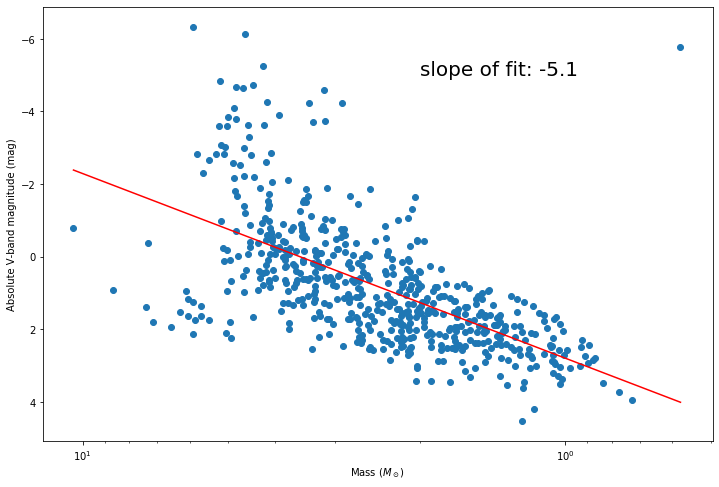

In [9]:
m,c = np.polyfit(np.log10(masslist),Mv_filtered,1)
x = np.linspace(min(masslist),max(masslist))
y = m*np.log10(x) + c

print('Slope:', m)
print('Intercept:',c)
slope_text = 'slope of fit: %.1f' % m

fig,ax = plt.subplots(figsize = (12,8))
plt.rcParams.update({'font.size':20})
plt.scatter(masslist,Mv_filtered)
plt.plot(x,y,color='red')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Absolute V-band magnitude (mag)')
plt.xscale('log')
plt.text(2,-5,slope_text)
ax.invert_yaxis()
ax.invert_xaxis()
plt.show()

***Figure 1.*** Plot of V-band absolute magnitude as a function of mass for stars in NGC 3293. The mass is shown on a log scale. The stars are shown as blue dots, while a linear fit is shown in red. The fit has a slope of $-5.1$. Bright high-mass stars are shown in the top left corner of the plot, while dim low-mass stars are in the bottom right.

The stars on the far left of the graph, with high inferred masses, do not correspond to the fit very well. This is likely because there are a number of blue stars on the isochrone plots with very similar B-V colours but of a wide range of brightnesses. Since we have used the B-V colour to infer the mass, we end up with stars with similar masses but of various V-band magnitudes, causing this large spread at high masses. 

There is also a single outlier in the top right. From the isochrone plots, we find a single red giant branch star, with a V-band magnitude corresponding to this outlier. The temperature-mass relation that we used to determine the masses is for main sequence stars, so the red colour of this giant would mean that it was mistakenly inferred to have a low mass. As such, I will perform this analysis again with the giant star excluded.

Slope: -5.329859514642802
Intercept: 2.9071928518467427


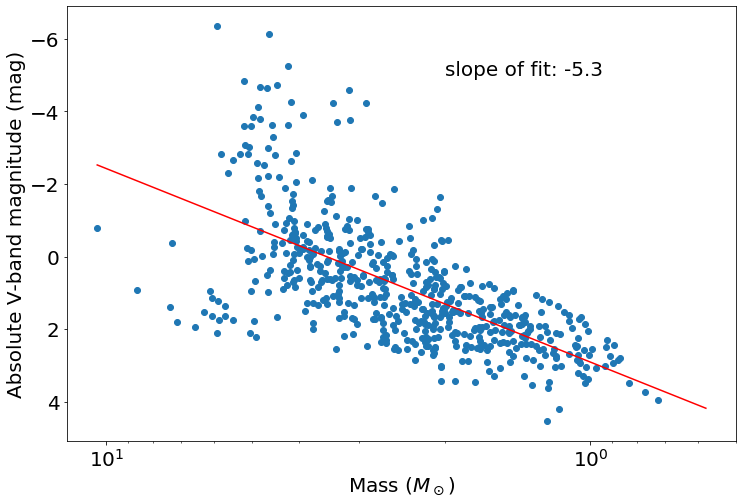

In [10]:
giant_idx = np.argmin(masslist)
masslist_no_giant = masslist[:giant_idx] + masslist[giant_idx+1:]
Mv_filtered_no_giant = np.concatenate((Mv_filtered[:giant_idx], Mv_filtered[giant_idx+1:]))


m,c = np.polyfit(np.log10(masslist_no_giant),Mv_filtered_no_giant,1)
x = np.linspace(min(masslist),max(masslist))
y = m*np.log10(x) + c

print('Slope:', m)
print('Intercept:',c)
slope_text = 'slope of fit: %.1f' % m

fig,ax = plt.subplots(figsize = (12,8))
plt.rcParams.update({'font.size':20})
plt.scatter(masslist_no_giant,Mv_filtered_no_giant)
plt.plot(x,y,color='red')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Absolute V-band magnitude (mag)')
plt.xscale('log')
plt.text(2,-5,slope_text)
ax.invert_yaxis()
ax.invert_xaxis()
plt.show()

***Figure 2.*** Plot of V-band absolute magnitude as a function of mass for stars in NGC 3293, excluding the giant star. The mass is shown on a log scale. The stars are shown as blue dots, while a linear fit is shown in red. The fit has a slope of $-5.3$. Bright high-mass stars are shown in the top left corner of the plot, while dim low-mass stars are in the bottom right.

I have also plotted the luminosity as a function of mass. I have used the equation
$$L = L_\odot 10^{(M_\odot-M_V)/2.5},$$

assuming that the Sun has a V-band absolute magnitude of 4.81 mag (Willmer 2018) (DOI = 10.3847/1538-4365/aabfdf).

Slope: 2.1319438058571203
Intercept: 0.761122859261303


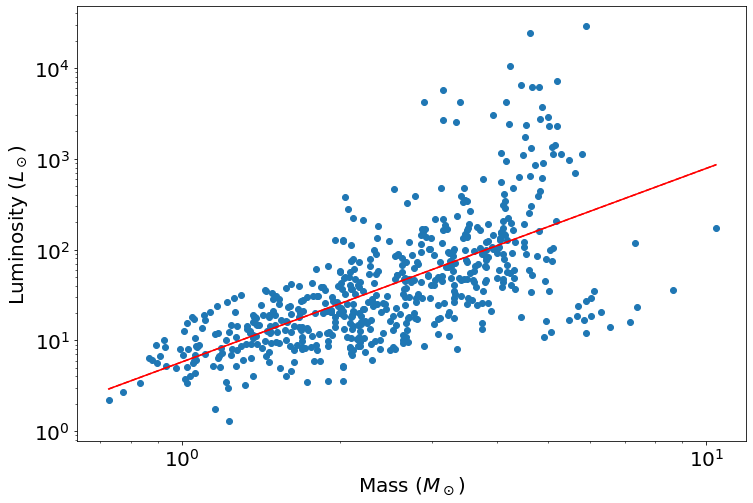

In [27]:
Mv_filtered_no_giant = np.array(Mv_filtered_no_giant)
L = 10**((4.81-Mv_filtered_no_giant)/2.5)


m,c =np.polyfit(np.log10(masslist_no_giant),np.log10(L),1)
x = np.linspace(min(masslist_no_giant),max(masslist_no_giant),10)
y = 10**c*x**m

print('Slope:', m)
print('Intercept:',c)

fig,ax = plt.subplots(figsize = (12,8))
plt.rcParams.update({'font.size':20})
plt.scatter(masslist_no_giant,L)
plt.plot(x,y,color='red')
plt.plot(x,y,color='red',linestyle='--')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Luminosity ($L_\odot$)')
plt.xscale('log')
plt.yscale('log')
plt.show()

***Figure 3.*** Plot of luminosity as a function of mass for stars in NGC 3293, excluding the giant star. The mass and luminsoity are both shown on a log scale. The stars are shown as blue dots, while a linear fit is shown in red. The fit has a slope of $2.1$. Bright high-mass stars are shown in the top right corner of the plot, while dim low-mass stars are in the bottom left.

We have performed a linear fit to the log-log plot,
$$\log(L) = a\log(M) + c,$$
where $a$ is the slope and $c$ the intercept. the luminosity $L$ and mass $M$ are in solar units. 

This linear fit corresponds to a power law of
$$
\begin{align}
L &= 10^\left(a\log(M) + c\right)\\
&= 10^\left(\log(10^c M^a) \right)\\
&= 10^c M^a.
\end{align}
$$

The mass-luminosity relation is often given as a proportionality $L\propto M^a$. The slope of our linear fit is $a=2.1$, while the literature value of the slope of the mass-luminosity relation is typically between $3$ and $5$ for stars in this mass range. I have not been able to find a literature value for the mass-luminosity relation of NGC 3293 in particular, so I am uncertain if this slope is unexpected for NGC 3293. One reason for the discrepancy could be the inaccurate inferred mass for the bluer stars, as mentioned above in relation to Figure 1. However, the fit looks quite good for the low-mass stars, so it is unlikely that this is solely to blame unless the conversion of colours to masses is inaccurate for the other stars as well.